In [101]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.models import Model
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [130]:
# Setting these as global variables so that they can be shuffled to ensure an even distribution- many times I wasn't getting all 24/720 labels in the validation set

images = np.load('75/images.npy')
images = images.astype('float32')

# Function that shuffles the images and labels into training, validation, and test sets
def initialize():
    global imgs, train_imgs, val_imgs, test_imgs, train_labels, val_labels, test_labels, distributed
    indices = np.random.permutation(images.shape[0])
    imgs = images[indices]
    labels = np.load('75/labels.npy')
    labels = labels.astype('int32')
    labels = labels[indices]

    split_1 = int(18000*0.8)
    split_2 = int(18000*0.9)

    train_imgs = imgs[:split_1]
    train_labels = labels[:split_1]
    
    val_imgs = imgs[split_1:split_2]
    val_labels = labels[split_1:split_2]
    
    test_imgs = imgs[split_2:]
    test_labels = labels[split_2:]

    # Normalizing the images
    train_imgs = train_imgs / 255.0
    test_imgs = test_imgs / 255.0
    val_imgs = val_imgs / 255.0


    train_imgs = train_imgs.reshape((train_imgs.shape[0], 75, 75, 1))
    val_imgs = val_imgs.reshape((val_imgs.shape[0], 75, 75, 1))
    test_imgs = test_imgs.reshape((test_imgs.shape[0], 75, 75, 1))

    print(train_imgs.shape, val_imgs.shape, test_imgs.shape)

## Classification Model

In [131]:
# Convert the time into 24 separate labels
def conv_time_24(time):
    ntime = 0
    if time[1] > 30:
        ntime = (time[0] + 0.5)
    else:
        ntime = time[0]
    return ntime

# Convert the time into 720 separate labels 
def conv_time_360(time):
    if time[1] % 2 == 0:
        return time[0]*60+time[1]
    else :
        return time[0]*60+time[1]-1

conv_time = conv_time_24
while True:
    initialize()
    train_labels_converted = np.array([conv_time(time) for time in train_labels])
    test_labels_converted = np.array([conv_time(time) for time in test_labels])
    val_labels_converted = np.array([conv_time(time) for time in val_labels])

    encoder = LabelEncoder()
    test_labels_encoded = encoder.fit_transform(test_labels_converted.reshape(-1))
    train_labels_encoded = encoder.fit_transform(train_labels_converted.reshape(-1))
    val_labels_encoded = encoder.fit_transform(val_labels_converted.reshape(-1))

    OHencoder = OneHotEncoder(sparse_output=False)
    train_labels_oh = OHencoder.fit_transform(train_labels_encoded.reshape(-1, 1))
    val_labels_oh = OHencoder.fit_transform(val_labels_encoded.reshape(-1, 1))
    
    # Check if all labels are present in the validation set, if not, reshuffle
    try:
        val_labels_oh = val_labels_oh.reshape((val_labels_oh.shape[0], 24))
        break
    except:
        pass

(14400, 75, 75, 1) (1800, 75, 75, 1) (1800, 75, 75, 1)


In [80]:
import tensorflow.keras.backend as K

#Common sense error function- checks the smaller of the differences by converting to military time
def common_sense_error(true, pred):
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

In [126]:
input_shape = (75, 75, 1)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32))
model.add(keras.layers.Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=input_shape))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=512, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=64, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=32, activation="relu"))
# Output layer - one neuron for each class label
model.add(keras.layers.Dense(units=24, activation="softmax"))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/vol/home/s4201388/Documents/Leiden/IDL/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [127]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

classification_history = model.fit(train_imgs, train_labels_oh, epochs=10, batch_size=256, validation_data=(val_imgs, val_labels_oh), callbacks=[early_stop])

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.0399 - loss: 3.1785 - val_accuracy: 0.0400 - val_loss: 3.1785
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0429 - loss: 3.1778 - val_accuracy: 0.0347 - val_loss: 3.1789
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0425 - loss: 3.1776 - val_accuracy: 0.0347 - val_loss: 3.1792
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0447 - loss: 3.1779 - val_accuracy: 0.0347 - val_loss: 3.1794
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0506 - loss: 3.1765 - val_accuracy: 0.0347 - val_loss: 3.1795
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0459 - loss: 3.1771 - val_accuracy: 0.0347 - val_loss: 3.1796
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0434 - loss: 3.1776 - val_accuracy: 0.0347 - val_loss: 3.1796
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0453 - loss: 3.1781 - val_accuracy: 0.0347 - v

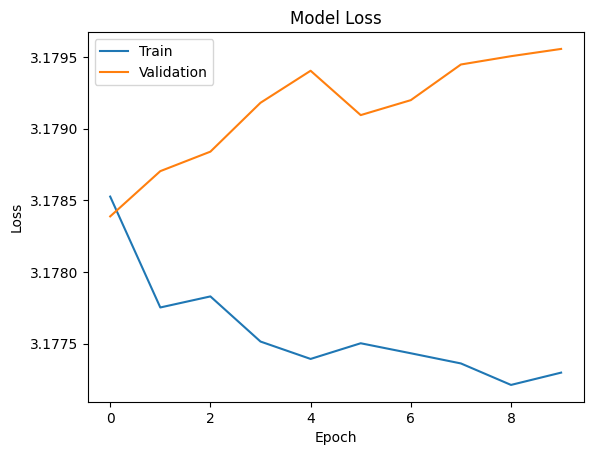

In [124]:
# Graph the model training
plt.plot(classification_history.history['loss'])
plt.plot(classification_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [125]:
# Measuring accuracy- picking the highest confidence label and comparing it to the true label
preds = model.predict(test_imgs)
preds = np.argmax(preds, axis=1)

results = encoder.inverse_transform(preds)
accuracy = np.sum(results == test_labels_converted) / len(test_labels_converted)
print(accuracy*100, '%')

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4.277777777777778 %


## Regression Model

In [98]:
import tensorflow.keras.backend as K

#returning the common sense difference between two times
def common_sense_error(true, pred):
    true = K.cast(true, 'float32')
    diff_1 = K.abs(true - pred)
    diff_2 = K.abs(true - (pred + 12))

    return K.minimum(diff_1, diff_2)

In [104]:
initialize()

# Convert the time into a continuous value
def conv_time(time):
    return round(time[0] + time[1]/60, 3)

train_labels_reg = np.array([conv_time(time) for time in train_labels])
test_labels_reg = np.array([conv_time(time) for time in test_labels])
val_labels_reg = np.array([conv_time(time) for time in val_labels])

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(activation='relu', filters=32, kernel_size=(3,3), input_shape=(75, 75, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.Conv2D(filters=32 ,kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=1, activation="softplus"))
model.compile(loss="mse", optimizer="adam", metrics=[common_sense_error])

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

model.fit(train_imgs, train_labels_reg, epochs=10, batch_size = 512, validation_data = (val_imgs, val_labels_reg), callbacks = [early_stop])

/vol/home/s4201388/Documents/Leiden/IDL/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - common_sense_error: 3.0244 - loss: 21.4115 - val_common_sense_error: 2.9458 - val_loss: 11.6759
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - common_sense_error: 3.0045 - loss: 12.2574 - val_common_sense_error: 2.9513 - val_loss: 11.6764
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - common_sense_error: 3.0260 - loss: 12.3975 - val_common_sense_error: 2.9384 - val_loss: 11.7714
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - common_sense_error: 3.0095 - loss: 12.1958 - val_common_sense_error: 2.9462 - val_loss: 11.6280
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - common_sense_error: 3.0027 - loss: 12.1453 - val_common_sense_error: 2.9468 - val_loss: 11.6083
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - common_sense_error: 3.0448 - loss: 12.3783 - val_common_sense_error: 2.9508 - val_loss: 11.6012
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - common_sense_error: 3.0318 - loss: 12.3046 - v

In [105]:
# Measuring accuracy within 1 minute of the true time
reg_preds = model.predict(test_imgs)
accuracy = np.mean(abs(reg_preds - test_labels_reg) < 0.16)
print(accuracy*100, '%')

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
2.480956790123457 %


## Two-Headed Model

In [38]:
initialize()

train_hours = train_labels[:, 0]
train_minutes = train_labels[:, 1]

val_hours = val_labels[:, 0]
val_minutes = val_labels[:, 1]

test_hours = test_labels[:, 0]
test_minutes = test_labels[:, 1]

train_minutes = train_minutes / 60
test_minutes = test_minutes / 60
val_minutes = val_minutes / 60

In [17]:
import tensorflow.keras.backend as K

def common_sense_hour(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

def common_sense_minute(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+60-true)
    return K.minimum(diff1, diff2)

In [40]:
inp = keras.layers.Input(shape = (75,75,1))
model = keras.layers.Convolution2D(32,kernel_size = (5,5), strides= (2,2), activation = "relu")(inp)
model = keras.layers.MaxPooling2D(pool_size =2)(model)
model = keras.layers.Convolution2D(32,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.Convolution2D(32,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.MaxPooling2D(pool_size =2)(model)
model = keras.layers.Convolution2D(64,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.Convolution2D(64,kernel_size = (1,1),activation = "relu")(model)
model = keras.layers.Flatten()(model)

d = keras.layers.Dense(256,activation = "relu")(model)
d = keras.layers.Dense(256,activation = "relu")(d)
d = keras.layers.Dropout(0.1)(d)
d = keras.layers.Dense(256,activation = "relu")(d)

# The hour head predicts confidence amonst 12 label classes- one for each hour 
hour = keras.layers.Dense(256,activation = "relu")(d)
hour = keras.layers.Dense(128,activation = "relu")(hour)
hour = keras.layers.Dense(64,activation = "relu")(hour)
hour = keras.layers.Dense(32,activation = "relu")(hour)
hour = keras.layers.Dense(16,activation = "relu")(hour)
hour = keras.layers.Dense(12,activation= "softmax", name= "hour")(hour)

# The minute head runs a regression on a continuous value
minute = keras.layers.Dense(256,activation = "relu")(d)
minute = keras.layers.Dense(256,activation = "relu")(minute)
minute = keras.layers.Dense(256,activation = "relu")(minute)
minute = keras.layers.Dense(128,activation = "relu")(minute)
minute = keras.layers.Dense(64,activation = "relu")(minute)
minute = keras.layers.Dense(32,activation = "relu")(minute)
minute = keras.layers.Dense(16,activation = "relu")(minute)
minute = keras.layers.Dense(1, activation = "softplus", name = "minute")(minute)

model = tf.keras.models.Model(inputs=inp, outputs=[hour, minute])
optim = tf.keras.optimizers.Adam()
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=optim, metrics=['accuracy',"mae"])

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

model.fit(train_imgs, [train_hours, train_minutes], epochs=30, batch_size = 512, validation_data = (val_imgs, [val_hours, val_minutes]), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - hour_accuracy: 0.0877 - hour_loss: 2.4857 - loss: 2.5919 - minute_loss: 0.1062 - minute_mae: 0.2738 - val_hour_accuracy: 0.0781 - val_hour_loss: 2.4853 - val_loss: 2.5691 - val_minute_loss: 0.0831 - val_minute_mae: 0.2513
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - hour_accuracy: 0.0821 - hour_loss: 2.4849 - loss: 2.5689 - minute_loss: 0.0840 - minute_mae: 0.2512 - val_hour_accuracy: 0.0800 - val_hour_loss: 2.4854 - val_loss: 2.5690 - val_minute_loss: 0.0829 - val_minute_mae: 0.2513
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - hour_accuracy: 0.0903 - hour_loss: 2.4848 - loss: 2.5692 - minute_loss: 0.0844 - minute_mae: 0.2511 - val_hour_accuracy: 0.0794 - val_hour_loss: 2.4859 - val_loss: 2.5700 - val_minute_loss: 0.0844 - val_minute_mae: 0.2519
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - hour_accuracy: 0.0829 - hour_loss: 2.4849 - loss: 2.5684 - minute_loss: 0.0835 - minute_mae: 0.2496 - val_hour_accuracy: 0

In [22]:
predictions = model.predict(test_imgs)
hour_p = np.argmax(predictions[0], axis = 1)
minutes_p = predictions[1]

accuracy = np.mean(np.abs(hour_p - test_hours) < 1) * np.mean(np.abs(minutes_p - test_minutes) < 5)
print(accuracy*100, '%')

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7.222222222222221 %
